In [2]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests

In [3]:
cnx = mysql.connector.connect(user='david', password='daviddung1993',
                              host='127.0.0.1',
                              database='computervision')
cursor = cnx.cursor()

In [4]:
headers = {"x-api-key": "M7HSjQNeTfai6l7JUiDZB8XYc85BHnHt3R0NXSEd"}

## Get Dataset

In [14]:
test_paper_ids = []
with open(r'./test_papers.txt', 'r') as fp:
    for line in fp:
        x = line[:-1]
        test_paper_ids.append(x)

In [62]:
def fetch_paper_neighbours(paperID):
    cursor.execute("select distinct(p2.PaperID) from Papers p, referencedBy b, referencedBy b2, Papers p2, aff_info af where p.PaperID = %s and p.PaperID = b.ReferencedByID and b.ReferenceID = b2.ReferenceID and p.PaperID != b2.ReferencedByID and b2.ReferenceID = p2.PaperID and p2.PaperID = af.PaperID and af.info >= 0.9 and p.`primary author` = p2.`primary author`", [paperID])
    paper_identical = len(cursor.fetchall())
    cursor.execute("select distinct(p2.PaperID) from Papers p, referencedBy b, referencedBy b2, Papers p2, aff_info af where p.PaperID = %s and p.PaperID = b.ReferencedByID and b.ReferenceID = b2.ReferenceID and p.PaperID != b2.ReferencedByID and b2.ReferenceID = p2.PaperID and p2.PaperID = af.PaperID and af.info >= 0.9", [paperID])
    paper_neighbours = len(cursor.fetchall())
    return paper_neighbours, paper_identical

In [151]:
test_papers = []
papers_distribution = []
paper_identical = []
for idx, test_paper_id in enumerate(test_paper_ids):
    if idx % 100 == 0:
        print(idx)
    a,b = fetch_paper_neighbours(test_paper_id)
    if b >= 3:
        test_papers.append(test_paper_id)
        continue
    papers_distribution.append(a)
    paper_identical.append(b)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


In [152]:
test = list(zip(papers_distribution, paper_identical))
#list(filter(lambda x: x[1]>=2, test))

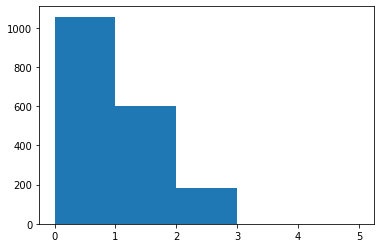

In [153]:
plt.hist(paper_identical, range=(0,5), bins=5)
plt.show()

In [66]:
cursor.fetchall()

[('0f885fd46064d271d4404cf9bb3d758e1a6f8d55',),
 ('1e56e0f525ab59d8a2fef5ef4a0b737323488052',),
 ('2c03df8b48bf3fa39054345bafabfeff15bfd11d',),
 ('36ad8eaa6d01ceec2efda3a9563320822920088f',),
 ('3d1e82b69663758a1db87fbebed6525d23090146',),
 ('540b5b4919d345e4da3cc4f3e8a7862329bf41a2',),
 ('71b7178df5d2b112d07e45038cb5637208659ff7',),
 ('7d39d69b23424446f0400ef603b2e3e22d0309d6',),
 ('9831dc24bba0aaaf32218989a5259d9110437950',)]

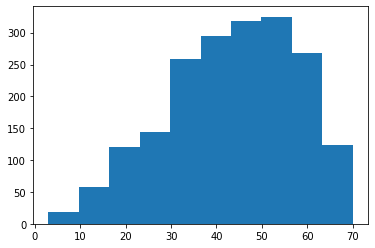

In [56]:
plt.hist(papers_distribution)
plt.show()

# Vector Space classifier

In [15]:
def map_class_to_vector(class_names, classes):
    binary_vector = [1 if c in class_names else 0 for c in classes]
    return binary_vector

def cosine_similarity(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    magnitude_v1 = np.linalg.norm(vector1)
    magnitude_v2 = np.linalg.norm(vector2)
    return dot_product / (magnitude_v1 * magnitude_v2)

def add_authors(paper_id_batch):
    authors_dict = {}
    response = requests.post("https://api.semanticscholar.org/graph/v1/paper/batch?fields=authors", json={"ids": paper_id_batch}).json()
    for paper in response:
        authors_dict[paper["paperId"]] = [x["authorId"] for x in paper["authors"] if x["authorId"]]
    return authors_dict


In [16]:
def references_from_database(all_papers):
    all_references = []
    cursor.execute("select distinct(p2.PaperID) from Papers p, referencedBy b, referencedBy b2, Papers p2 where p.PaperID = %s and p.PaperID = b.ReferencedByID and b.ReferenceID = b2.ReferenceID and p.PaperID != b2.ReferencedByID and b2.ReferenceID = p2.PaperID", [paperID])
    neighbour_papers =  cursor.fetchall()
    all_papers.extend([paper[0] for paper in neighbour_papers])
    in_params = ','.join(['%s'] * len(all_papers))
    cursor.execute("select b.ReferencedByID, group_concat(b.ReferenceID), group_concat(a.AuthoredByID) from referencedBy b, Papers p, authoredBy a where b.ReferencedByID in (%s) and b.ReferencedByID = p.PaperID and p.PaperID = a.PaperID group by b.ReferencedByID having count(*)>=5" % in_params, all_papers)
    all_mapped_references = cursor.fetchall()
    for idx, x in  enumerate(all_mapped_references):
        all_references.extend(x[1].split(","))
        all_mapped_references[idx] = (all_mapped_references[idx][0], all_mapped_references[idx][1], all_mapped_references[idx][2].split(","))
    all_references = list(set(all_references))
    return all_references, all_mapped_references

def fetch_from_scholar(all_papers):
    all_mapped_references = []
    all_references = []
    paper_id = all_papers[0]
    already_visited = [paper_id]
    paper_link = f"https://api.semanticscholar.org/graph/v1/paper/{paper_id}?fields=references,references.citationCount,authors"
    response = requests.get(paper_link, headers=headers).json()
    primary_author_id = [x["authorId"] for x in response["authors"]]
    primary_author_id_set = set([x["authorId"] for x in response["authors"]])
    reference_ids = [x["paperId"] for x in response["references"] if x["paperId"]]
    if not len(reference_ids):
        return ValueError
    reference_ids_string = ",".join(reference_ids)
    all_mapped_references.append((paper_id, reference_ids_string, primary_author_id))

    for idx, reference_id in enumerate(reference_ids):
        print(f"{idx}/{len(reference_ids)}")
        link = f"https://api.semanticscholar.org/graph/v1/paper/{reference_id}?fields=citations,citations.authors"
        resp = requests.get(link, headers=headers).json()
        if "citations" not in resp:
            continue
        citations = resp["citations"]
        cit = []
        same_authors = [1 if len(set([a["authorId"] for a in x["authors"]]).intersection(primary_author_id_set)) > 0 else 0 for x in resp["citations"]]
        for idx, element in enumerate(same_authors):
            if element:
                cit.append(citations[idx])
        cit.extend(citations)
        for citation in cit[:30]:
            if citation["paperId"] and citation["paperId"] not in already_visited:
                citation_link = f"https://api.semanticscholar.org/graph/v1/paper/{citation['paperId']}?fields=references,authors"
                citation_resp = requests.get(citation_link, headers=headers).json()
                already_visited.append(citation["paperId"])
                if not "authors" in citation_resp:
                    continue
                if not citation_resp["authors"]:
                    continue
                citation_primary_author_id = [x["authorId"] for x in citation_resp["authors"]]
                if not citation_primary_author_id:
                    continue
                citation_reference_ids = [x["paperId"] for x in citation_resp["references"] if x["paperId"]]
                if len(citation_reference_ids) < 6:
                    continue
                citation_reference_string = ",".join(citation_reference_ids)
                all_mapped_references.append((citation["paperId"], citation_reference_string, citation_primary_author_id))

    for x in  all_mapped_references:
        all_references.extend(x[1].split(","))
    all_references = list(set(all_references))
    return all_references, all_mapped_references

def classifier(paperID, classify_from_database=True):
    all_papers = [paperID]
    all_mapped_references = []
    # Fetch all papers that have at least one reference in common:
    if classify_from_database:
        all_references, all_mapped_references = references_from_database(all_papers)
    else:
        all_references, all_mapped_references = fetch_from_scholar(all_papers)

    test_paper_vector = None
    paper_ranking = {}
    author_correct = set(all_mapped_references[0][2])
    index_match = []
    for idx, mapped_references in enumerate(all_mapped_references):

        class_vector = map_class_to_vector(mapped_references[1].split(","), all_references)
        if idx == 0:
            test_paper_vector = class_vector
            continue
        similarity_index = cosine_similarity(test_paper_vector, class_vector)

        if len(author_correct.intersection(set(mapped_references[2]))) > 0:
            index_match.append(idx)
        paper_ranking[mapped_references[0]] = [similarity_index, mapped_references[2]]

    sorted_paper_ranking = sorted(paper_ranking.items(), key=lambda x:x[1][0], reverse=True)
    return sorted_paper_ranking, index_match, author_correct

def rank_authors(result, authors):
    author_ranking = {}
    # Weight
    weight_factor = len(result)
    fn = lambda x: weight_factor * ((1/1.09)**x)
    for idx, paper in enumerate(result):
        for author in paper[1][1]:
            if author not in author_ranking:
                author_ranking[author] = []
            author_ranking[author].append(idx)
    for author, indices in author_ranking.items():
        author_ranking[author] = sum([fn(x) for x in indices])
    author_match_indices = []
    author_ranking = sorted(author_ranking.items(), key=lambda x: x[1], reverse=True)
    author_ranking = list(filter(lambda x: x[0], author_ranking))
    for author in authors:
        author_match_indices.extend([x+1 for x, y in enumerate(author_ranking) if y[0] == author])
    return author_ranking, author_match_indices

In [17]:
hit = 0
current_id = 0
total_matches = []
total_authors_matches = []
total_run = 0
author_hit = 0
final = []
author_rankings = []
solution_test_papers = []

In [18]:
test_papers = test_paper_ids
len(test_papers)

1006

In [19]:
for idx,paperID in enumerate(test_papers): #[current_id:47]
    if idx < current_id:
        continue

    print(f"{idx}/{len(test_papers)}")
    try:
        result, matches, authors = classifier(paperID, classify_from_database=True)
        author_ranking, author_matches = rank_authors(result, authors)
    except (ValueError, TypeError):
        print("error")
        current_id = idx+1
        continue
    author_rankings.append(author_ranking)
    total_matches.append(matches)
    total_authors_matches.append(author_matches)
    final.append(result)
    if 1 in matches:
        #print("hit")
        hit += 1
    if 1 in author_matches:
        author_hit += 1
    total_run += 1
    current_id = idx+1
    solution_test_papers.append(paperID)
print(hit/total_run)
print(author_hit/total_run)

0/1006
1/1006
2/1006
3/1006
4/1006
5/1006
6/1006
7/1006
8/1006
9/1006
10/1006
11/1006
12/1006
13/1006
14/1006
15/1006
16/1006
17/1006
18/1006
19/1006
20/1006
21/1006
22/1006
23/1006
24/1006
25/1006
26/1006
27/1006
28/1006
29/1006
30/1006
31/1006
32/1006
33/1006
34/1006
35/1006
36/1006
37/1006
38/1006
39/1006
40/1006
41/1006
42/1006
43/1006
44/1006
45/1006
46/1006
47/1006
48/1006
49/1006
50/1006
51/1006
52/1006
53/1006
54/1006
55/1006
56/1006
57/1006
58/1006
59/1006
60/1006
61/1006
62/1006
63/1006
64/1006
65/1006
66/1006
67/1006
68/1006
69/1006
70/1006
71/1006
72/1006
73/1006
74/1006
75/1006
76/1006
77/1006
78/1006
79/1006
80/1006
81/1006
82/1006
83/1006
84/1006
85/1006
86/1006
87/1006
88/1006
89/1006
90/1006
91/1006
92/1006
93/1006
94/1006
95/1006
96/1006
97/1006
98/1006
99/1006
100/1006
101/1006
102/1006
103/1006
104/1006
105/1006
106/1006
107/1006
108/1006
109/1006
110/1006
111/1006
112/1006
113/1006
114/1006
115/1006
116/1006
117/1006
118/1006
119/1006
120/1006
121/1006
122/1006
123

In [387]:
print(hit/total_run)
print(author_hit/total_run)

0.5157894736842106
0.45263157894736844


In [201]:
first_ranked = []
percentages = []
for idx, x in enumerate(total_authors_matches):
    if x:
        x.sort()
        if x[0] == 1 or x[0] > 10:
            continue
        first_place = author_rankings[idx][0][1]
        next_place_match = author_rankings[idx][x[0]-1][1]
        percentage = (first_place-next_place_match)/next_place_match
        percentages.append(percentage)
        first_ranked.append(x[0])
sum(first_ranked)/len(first_ranked)
sum(percentages)/len(percentages)

0.5035330266429131

In [18]:
def weigh_paper_rankings(author_rankings, test_papers, total_authors_matches):
    params = ','.join(['%s'] * len(test_papers))
    cursor.execute("with temp as (select p.PaperID, a2.Country as co, count(*) as c from Papers p, referencedBy b, Papers p2, affiliatedTo a, Affiliations a2 where p.PaperID in (%s) and p.PaperID = b.ReferencedByID and b.ReferenceID = p2.PaperID and p2.`primary author` = a.AuthorID and a.affiliatedTo = a2.AffiliationID and a2.Country != 'None' group by p.PaperID, a2.Country)"
                   "select t.co from (select PaperID, max(c) as max_value from temp group by PaperID) t2, temp t where t2.PaperID = t.PaperID and t2.max_value = t.c" % params, test_papers)
    most_cited_countries = [x[0] for x in cursor.fetchall()]
    author_params = ','.join(['%s'] * 10)
    hita = 0
    for idx, x in enumerate(test_papers):
        correct_authors = []
        top_ten_authors = author_rankings[idx][:10]
        top_ranked_authors = [x[0] for x in top_ten_authors]
        cursor.execute("select a.AuthorID, a2.Country from affiliatedTo a, Affiliations a2 where a.AuthorID in (%s) and a.affiliatedTo = a2.AffiliationID and a2.Country is not null" % author_params, top_ranked_authors)
        matched_authors = [x[0] for x in list(filter(lambda x: x[1] == most_cited_countries[idx], cursor.fetchall()))]
        new_ranked_authors = sorted([(x[0],x[1]*2) if x[0] in matched_authors else x for x in top_ten_authors], key=lambda x: x[1], reverse=True)
        for match in total_authors_matches[idx]:
            correct_authors.append(author_rankings[idx][match-1][0])
        #if new_ranked_authors[0][0] != top_ranked_authors[0]:
            #print("changed")
        if new_ranked_authors[0][0] in correct_authors:
            hita += 1

    return hita/len(test_papers)
    #for idx, element in enumerate(test_papers):
    #    # determine the most cited country for the paper

In [19]:
weigh_paper_rankings(author_rankings, solution_test_papers, total_authors_matches)

0.55